In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

import joblib
import shap
from sklearn.inspection import PartialDependenceDisplay
from statsmodels.stats.proportion import proportions_ztest

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Improving Customer Rentention and Lifetime Value

In [2]:
# Download and load Customers dataset
file_id = '1l7Tsvp_1w0ZO3j6ktxlN-i_ZrR_MfcNW'
url = f'https://drive.google.com/uc?id={file_id}'
output1 = 'Customers.csv'
gdown.download(url, output1, quiet=False)

customers = pd.read_csv("Customers.csv", index_col=0)
customers.head()

Downloading...
From: https://drive.google.com/uc?id=1l7Tsvp_1w0ZO3j6ktxlN-i_ZrR_MfcNW
To: c:\Users\CelesteN\Documents\nus resources\dsa3101\Project\DSA3101-Project\customer_behaviour\Customers.csv
100%|██████████| 6.87M/6.87M [00:00<00:00, 10.8MB/s]


,CustomerID,Age,Gender,Payment Method,Churn,Tenure,Complain,NumberOfDeviceRegistered,SatisfactionScore,CouponUsed,CashbackAmount,HourSpendOnApp
0,0,33,Female,Cash,0,0.0,0,4,5,1.0,141.938896,4.0
1,1,17,Female,Cash,1,8.0,1,3,2,1.0,154.090267,2.0
2,2,42,Female,Cash,0,9.0,0,5,1,2.0,178.416467,4.0
3,3,37,Female,Cash,1,0.0,1,5,5,1.0,174.593679,4.0
4,4,63,Female,Cash,0,11.0,0,4,4,1.0,179.037919,2.0


In [3]:
customers.describe()

,CustomerID,Age,Churn,Tenure,Complain,NumberOfDeviceRegistered,SatisfactionScore,CouponUsed,CashbackAmount,HourSpendOnApp
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,49999.500000,43.333280,0.235460,8.215350,0.263620,3.75883,3.123860,1.514540,179.665308,2.748030
std,28867.657797,15.380321,0.424288,8.656932,0.440598,1.12977,1.379789,1.718388,51.678213,1.141873
min,0.000000,15.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,108.046324,0.000000
25%,24999.750000,30.000000,0.000000,1.000000,0.000000,3.00000,2.000000,0.000000,145.119455,2.000000
50%,49999.500000,43.000000,0.000000,6.000000,0.000000,4.00000,3.000000,1.000000,166.515184,3.000000
75%,74999.250000,57.000000,0.000000,13.000000,1.000000,4.00000,4.000000,2.000000,196.059475,4.000000
max,99999.000000,73.000000,1.000000,37.000000,1.000000,6.00000,5.000000,13.000000,324.990000,5.000000


## Churn Rates

Overall churn rates showed that `23.5%` of our 100,000 customers churned, which is quite high for an e-commerce platform. This requires further analysis to identify key reasons or features and to propose targeted retention strategies.

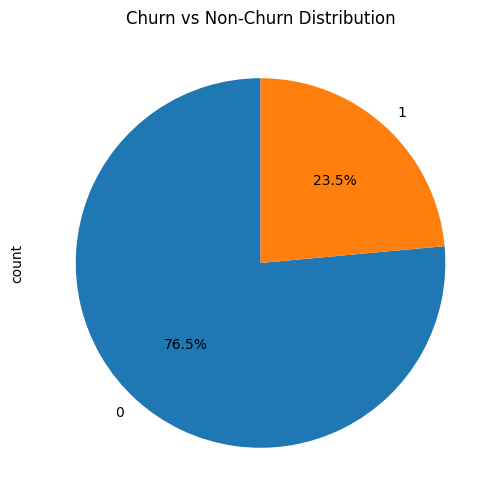

Churn Rate: 23.55%


In [4]:
# Calculate overall churn rates
n_cust = customers.shape[0]

overall_churn_rate = sum(customers['Churn']) * 100 / n_cust 

churn_counts = customers['Churn'].value_counts()
churn_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(6,6))
plt.title('Churn vs Non-Churn Distribution')
plt.show()

print(f"Churn Rate: {overall_churn_rate:.2f}%")

## Data Visualizations

In [5]:
# Mapping Gender for Correlation Matrix
customers['GenderMap'] = customers['Gender'].map({'Male': 1, 'Female': 0})

### Correlation Matrix

Based on the correlation heatmap, it can be observed that variables with highest correlation to Churn is `Tenure`, `Complain`, `CashbackAmount`,  and `NumberOfDeviceRegistered` (in decreasing order). Additionally, `CouponUsed` and `SatisfactionScore` may also be worth analyzing, as they show some correlation with churn as well.


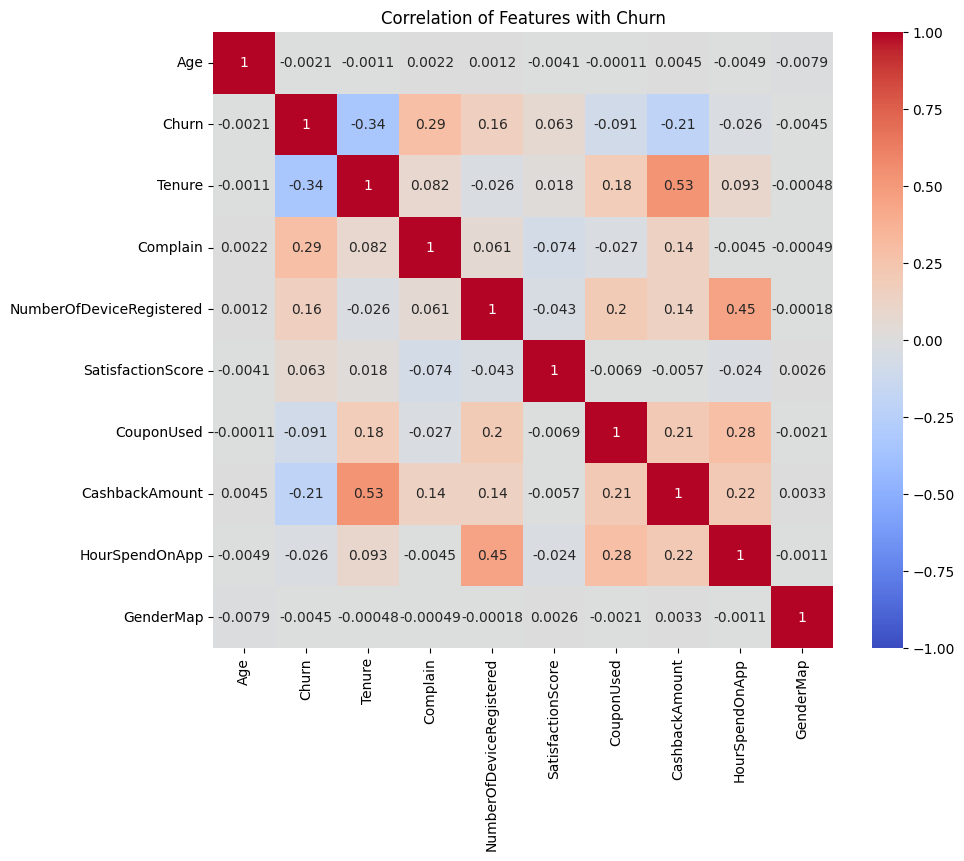

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(customers.drop(['CustomerID'], axis = 1).corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Features with Churn')
plt.show()

### KDE Plots

`Tenure`, which has the strongest correlation with churn, shows a clear trend: churned customers are concentrated in the 0–3 year range, while non-churned customers are more evenly distributed. The `CashbackAmount` distribution reveals peaks around $125 and $150 for churned customers, suggesting higher churn likelihood in this range. For `Age`, both churned and non-churned distributions appear similar, indicating little to no age correlation with churn.

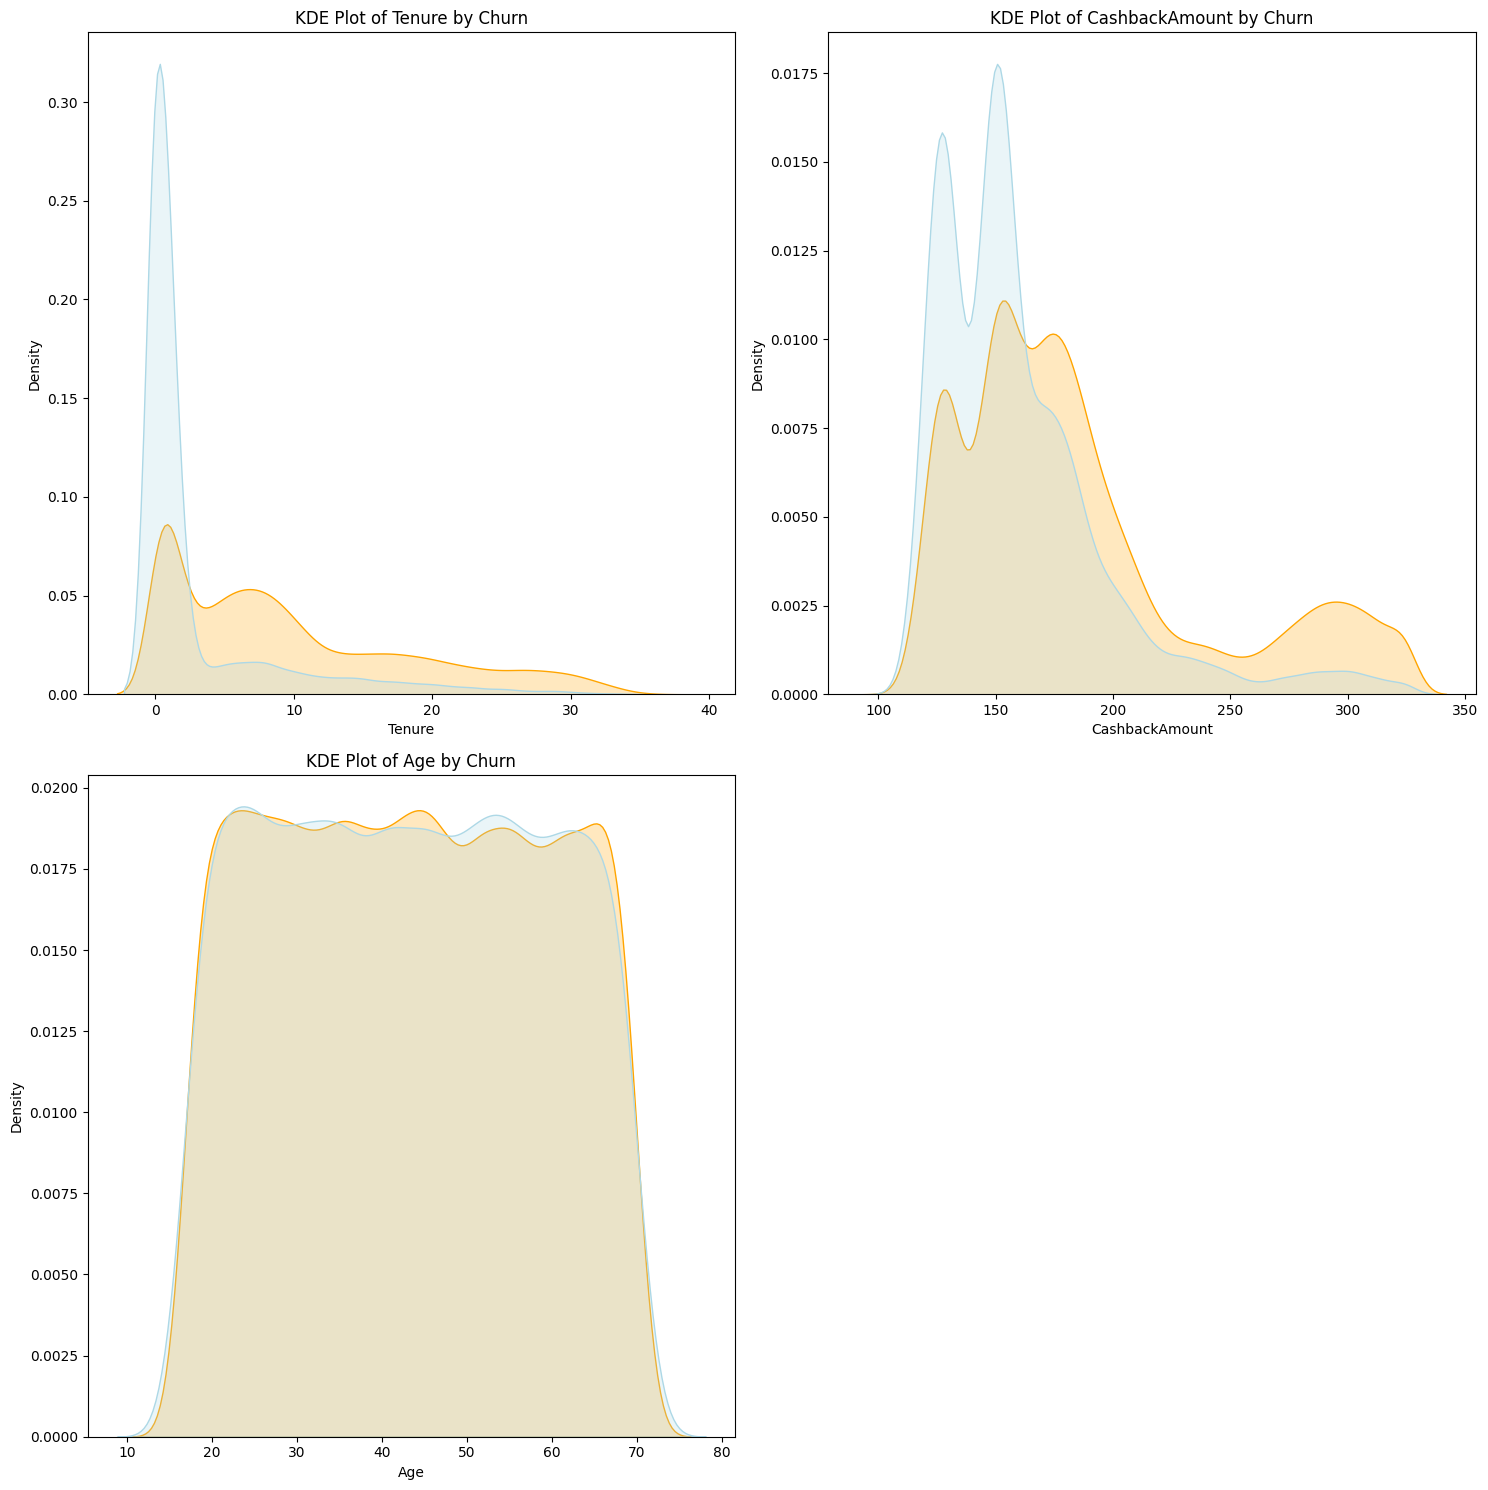

In [7]:
plt.figure(figsize=(15, 15))

cols = ['Tenure', 'CashbackAmount','Age']

for i, column in enumerate(cols):
    ax = plt.subplot(2,2, i+1)
    sns.kdeplot(customers[customers['Churn'] == 0][column], label='Non-Churned', fill=True, ax = ax, color='orange')
    sns.kdeplot(customers[customers['Churn'] == 1][column], label='Churned', fill=True, ax= ax, color='lightblue')
    ax.set_title(f'KDE Plot of {column} by Churn')
    ax.set_xlabel(f'{column}')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

### Bar Plot Distribution

Higher proportion of churned customers for `NumberOfDeviceRegistered` of 3, 5, and 6, suggesting that users with multiple devices are more prone to churn. Proportion of customers rating `SatisfactionScore` values of 3 and 4 are also higher for churned customers indicates that moderate satisfaction doesn’t guarantee retention.

For `Complain`, a greater proportion of churned customers have lodged complaints compared to non-churning customers, possibly indicating that unresolved issues likely drive churn. Similarly, the proportion of churned customers using 1 coupon is notably higher, followed by 0 and 3 coupons, suggesting that `CouponUsed` may impact retention, and incentivizing coupon use could be beneficial.

Lastly, `Payment Method` distributions are nearly identical for both churned and non-churning customers, implying that payment method likely has minimal impact on churn.

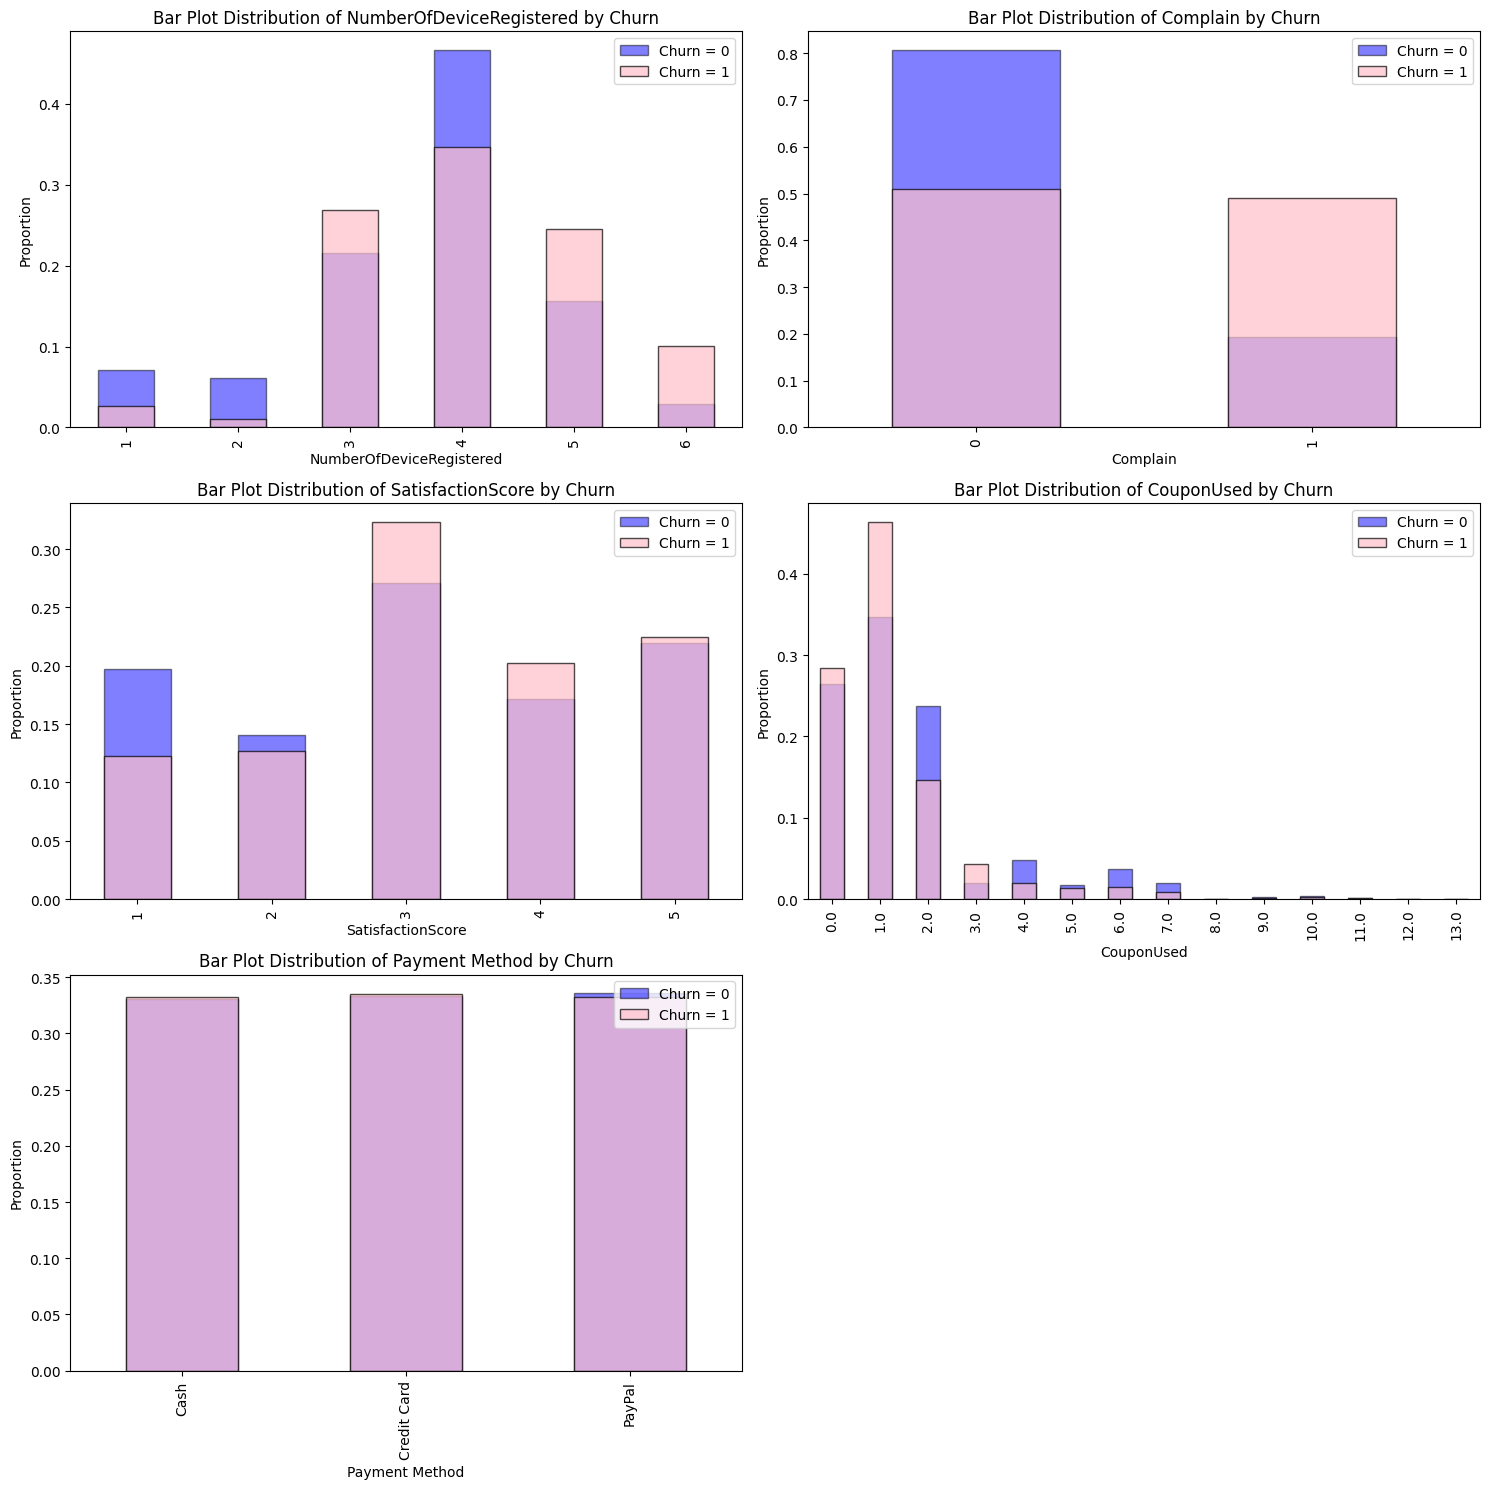

In [8]:
cols = ['NumberOfDeviceRegistered', 'Complain',
       'SatisfactionScore', 'CouponUsed', 'Payment Method']

plt.figure(figsize=(15, 15))

for i, column in enumerate(cols):
    plt.subplot(3, 2, i + 1)  
    
    # Calculate proportions
    churn_proportion = customers.groupby('Churn')[column].value_counts(normalize=True).unstack().fillna(0)
    
    # Plot for each churn category
    for churn_value in churn_proportion.index:  # Loop through Churn values (0 and 1)
        churn_proportion.loc[churn_value].plot(
            kind='bar', 
            alpha=0.5 if churn_value == 0 else 0.7,  # Set transparency for overlay effect
            color='b' if churn_value == 0 else 'pink', 
            edgecolor='black', 
            label=f'Churn = {churn_value}', 
            ax=plt.gca()  # Get current subplot
        )
    
    plt.title(f'Bar Plot Distribution of {column} by Churn')
    plt.xlabel(column)
    plt.ylabel('Proportion')
    plt.legend()

plt.tight_layout()
plt.show()


### Pie Chart of Churn By Gender

From the correlation matrix above, `Gender` has a low correlation with `Churn`. This is supported by the pie charts where the churn rates are similar for both male and female customers

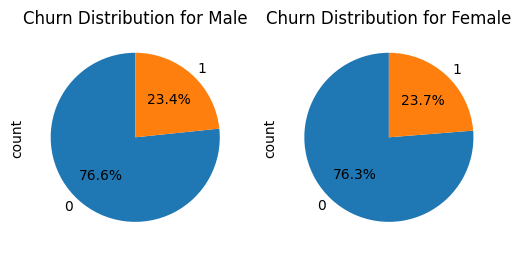

In [9]:
male = customers[customers['Gender'] == 'Male']
female = customers[customers['Gender'] != 'Male']

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
male['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(6,6))
plt.title('Churn Distribution for Male')

plt.subplot(1,2,2)
female['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(6,6))
plt.title('Churn Distribution for Female')
plt.show()

## Predictive Modelling 

Now, we will make use of machine learning models to find the features most important for predicting churn and thus characteristics of customers likely to churn, and identify at-risk customers.

In [10]:
customers_encoded = pd.get_dummies(customers, columns=['Payment Method'])

X = customers_encoded.drop(['Churn','Gender', 'CustomerID'], axis = 1)
y = customers_encoded['Churn']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Compare and select the best model with best F1 score
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),  # Optional scaling
        ('classifier', LogisticRegression())
    ]),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

# Iterate through models and perform cross-validation
# F1 score used to determine best model since it is an imbalanced binary classification problem
results = {}
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    results[model_name] = cv_scores

for model_name, scores in results.items():
    print(f"{model_name} F1 Score: {scores.mean():.4f} ± {scores.std():.4f}")

Logistic Regression F1 Score: 0.5186 ± 0.0064
Decision Tree F1 Score: 0.5263 ± 0.0043
Random Forest F1 Score: 0.5982 ± 0.0032


Among the 3 models, the F1 Score is the highest for Random Forest, so we will pick Random Forest as our predictive model for Churn prediction. Now, we will explore the best hyperparameter combinations to improve accuracy and robutness of model.

In [ ]:
param_grid = {
    'n_estimators': [300, 400, 500],       # Number of trees in the forest
    'max_depth': [10, 20, 30],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],         # Minimum number of samples required to be at a leaf node
    'bootstrap': [True]            # Whether to bootstrap samples
}

search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, n_iter=75,
                           cv=5, n_jobs=-1, scoring='f1', verbose=1, random_state=42)

# Commented out to prevent long model training from running again
# search.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=75,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [300, 400, 500]},
                   random_state=42, scoring='f1', verbose=1)

In [ ]:
# Get and save best model and parameters
# joblib.dump(search.best_params_, 'best_params.joblib')
# joblib.dump(search.best_estimator_, 'best_rf.joblib')

['best_rf.joblib']

In [13]:
# download required files
file_id = '1VNeyjV6y8qQPQ24jo64PaJhQV1vFLCU8'
url = f'https://drive.google.com/uc?id={file_id}'
output2 = 'best_params.joblib'

gdown.download(url, output2, quiet=False)

file_id = '1yZvl5xi4RKIAQJztp1pgHl24JAYMsrtS'
url = f'https://drive.google.com/uc?id={file_id}'
output3 = 'best_rf.joblib'

gdown.download(url, output3, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1VNeyjV6y8qQPQ24jo64PaJhQV1vFLCU8
To: c:\Users\CelesteN\Documents\nus resources\dsa3101\Project\DSA3101-Project\customer_behaviour\best_params.joblib
100%|██████████| 104/104 [00:00<00:00, 104kB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1yZvl5xi4RKIAQJztp1pgHl24JAYMsrtS
From (redirected): https://drive.google.com/uc?id=1yZvl5xi4RKIAQJztp1pgHl24JAYMsrtS&confirm=t&uuid=5f07cf70-0380-4983-8a98-52b6a054857b
To: c:\Users\CelesteN\Documents\nus resources\dsa3101\Project\DSA3101-Project\customer_behaviour\best_rf.joblib
100%|██████████| 335M/335M [00:38<00:00, 8.63MB/s] 


'best_rf.joblib'

In [14]:
best_params = joblib.load('best_params.joblib')
print("Best Parameters: ", best_params)

Best Parameters:  {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}


In [15]:
# Load best model (Random Forest with the best parameters)
best_rf = joblib.load('best_rf.joblib')

# Predict on the test set using the best model
y_pred = best_rf.predict(X_test)

# Evaluate the model
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8415
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     15282
           1       0.74      0.51      0.60      4718

    accuracy                           0.84     20000
   macro avg       0.80      0.73      0.75     20000
weighted avg       0.83      0.84      0.83     20000



## Identifying At-Risk Customers

### Using Churn Probabilties

Using churn probabilities from our predictive model, we identify customers at risk of churning. We then plot bar graphs to observe the distribution of key features and pinpoint the characteristics of at-risk customers.

In [16]:
customers_prob = customers_encoded

customers_prob['Probability'] = best_rf.predict_proba(X)[:, 1]

at_risk = customers_prob[(customers_prob['Churn'] == 0) & (customers_prob['Probability'] > 0.5)]

From the distribution analysis of at-risk customer features, we observe key trends that align with known churn indicators: short `Tenure` (less than 2 years), making `Complaint`, limited `CashbackAmount` received (mainly ~$125 to ~$150). 

Furthermore, they tend to have moderate app engagement (`HourSpendOnApp` mainly 2 hours), rate an average `SatisfactionScore` of 3 and have limited `CouponUsed` (0-2). 

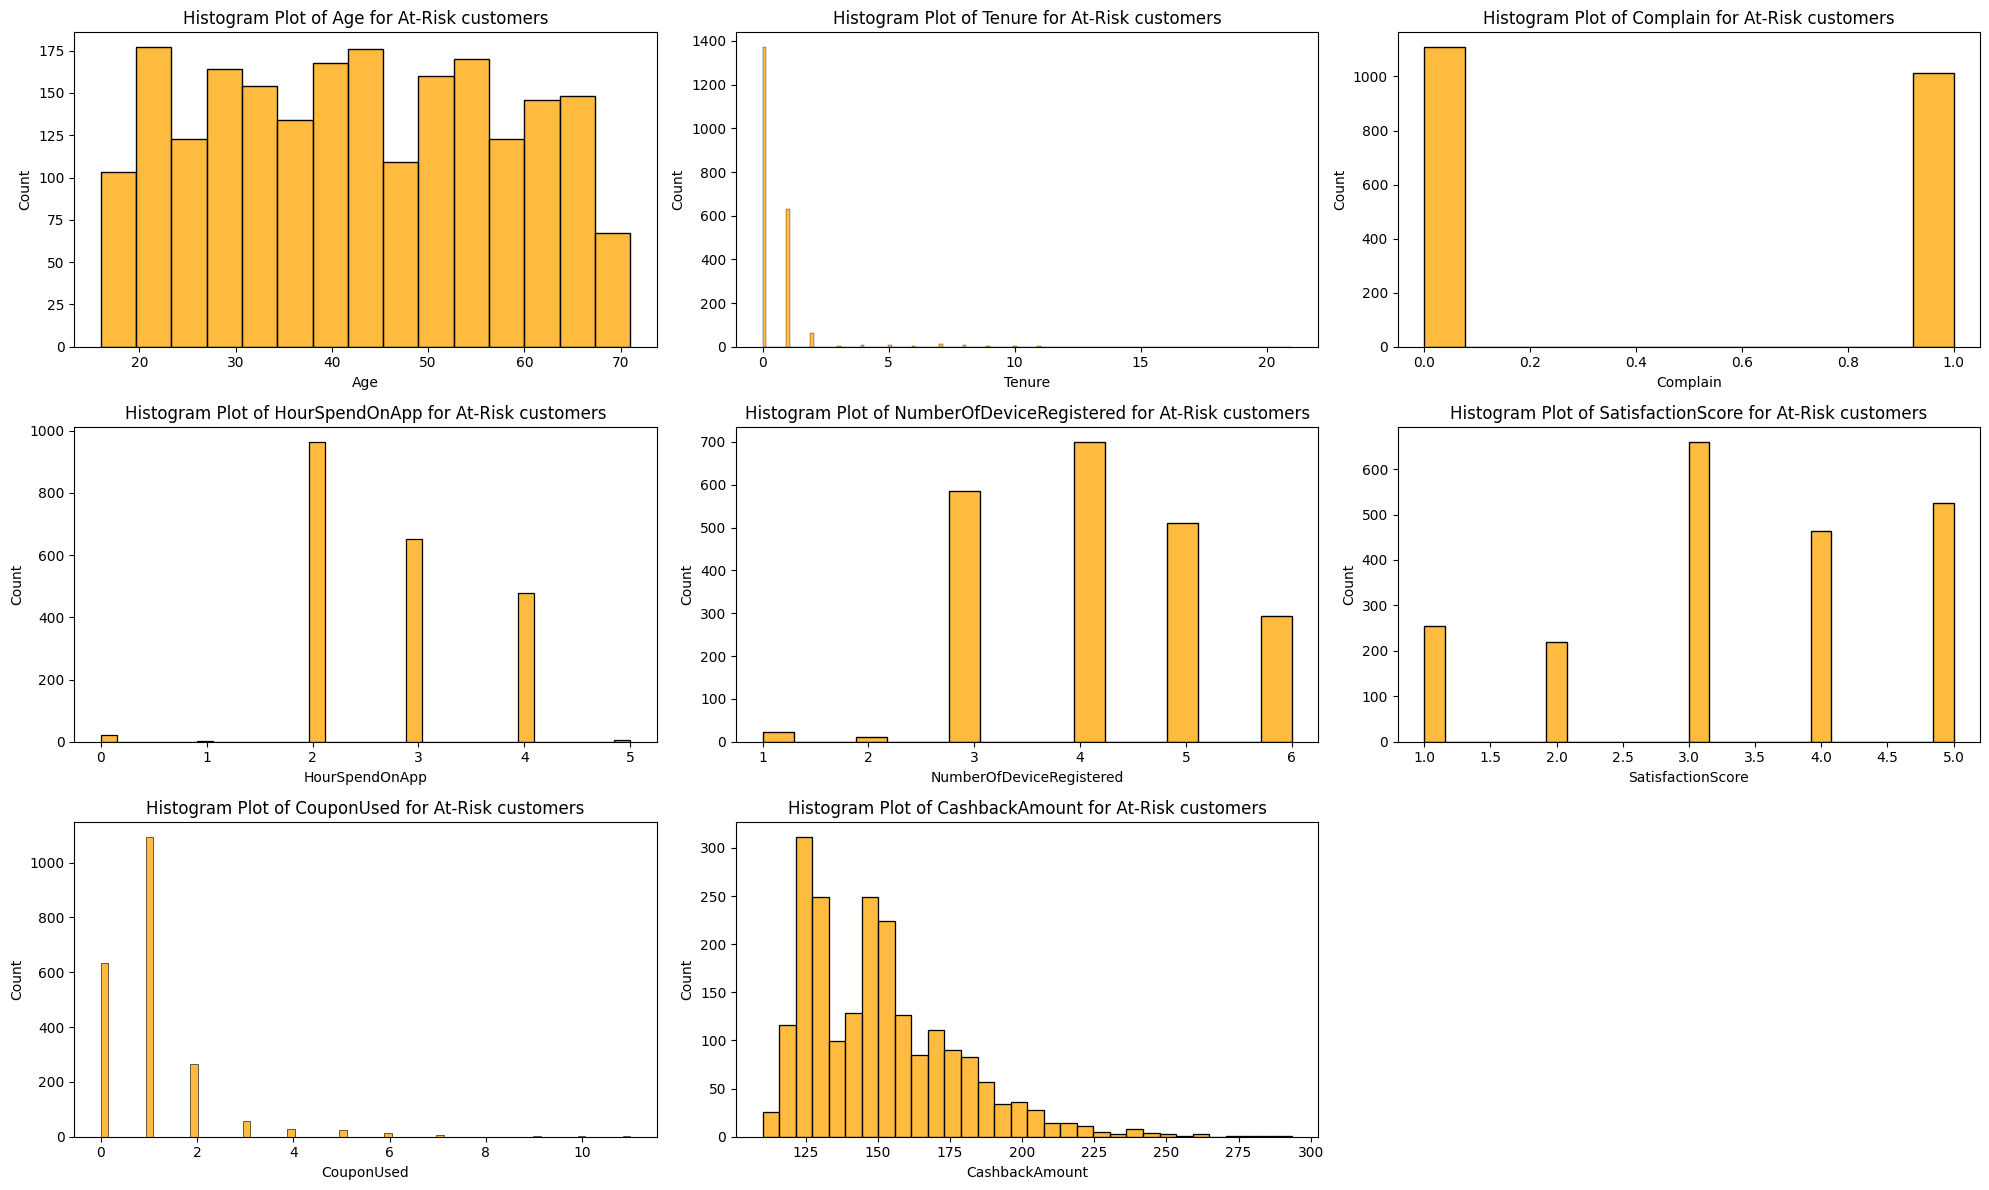

In [17]:
plt.figure(figsize=(20, 12))

cols = ['Age', 'Tenure', 'Complain','HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore',
       'CouponUsed','CashbackAmount']

for i, column in enumerate(cols):
    ax = plt.subplot(3,3, i+1)
    sns.histplot(at_risk[column], fill=True, ax = ax, color='orange')
    ax.set_title(f'Histogram Plot of {column} for At-Risk customers')
    ax.set_xlabel(f'{column}')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

### Feature Importance

Based on the feature importances from the Random Forest model, `Tenure`, `Complain`, `CashbackAmount`and `NumberOfDeviceRegistered` have the highest importance, aligning with expectations set by the correlation matrix. `CouponUsed` and `HourSpendOnApp` also surprisingly turned out to be important features for predicting churn. However, `SatisficationScore` does not have as much importance as expected.

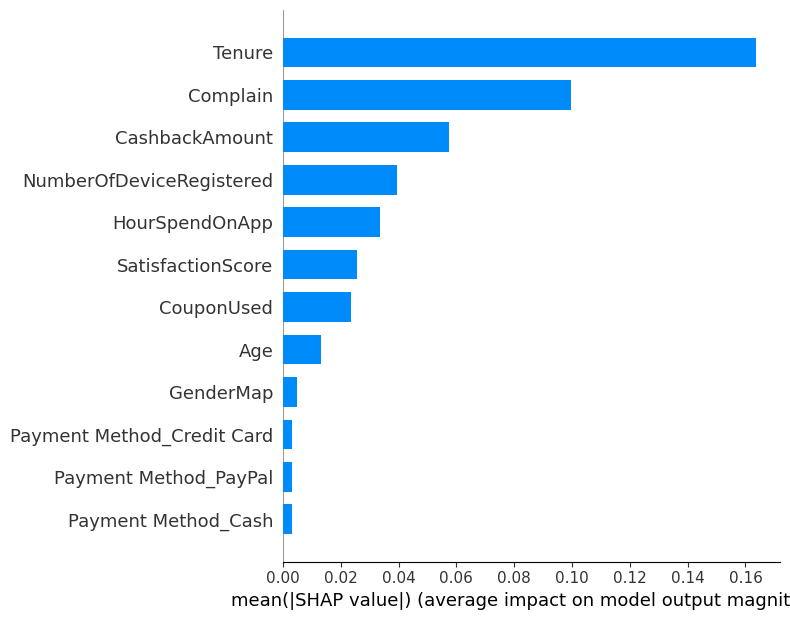

In [18]:
explainer = shap.TreeExplainer(best_rf)

shap_values = explainer.shap_values(X_test, approximate=True,)

# This plot shows which features are contributing the most to the model's predictions
shap.summary_plot(shap_values[...,1], X_test, plot_type="bar")

### Further Analysis into important features

SHAP (SHapley Additive exPlanations) plots help visualize the impact of each feature on the model's predictions.
Positive SHAP values push the prediction towards 1 (e.g., churn), while negative SHAP values push it towards 0 (e.g., no churn).

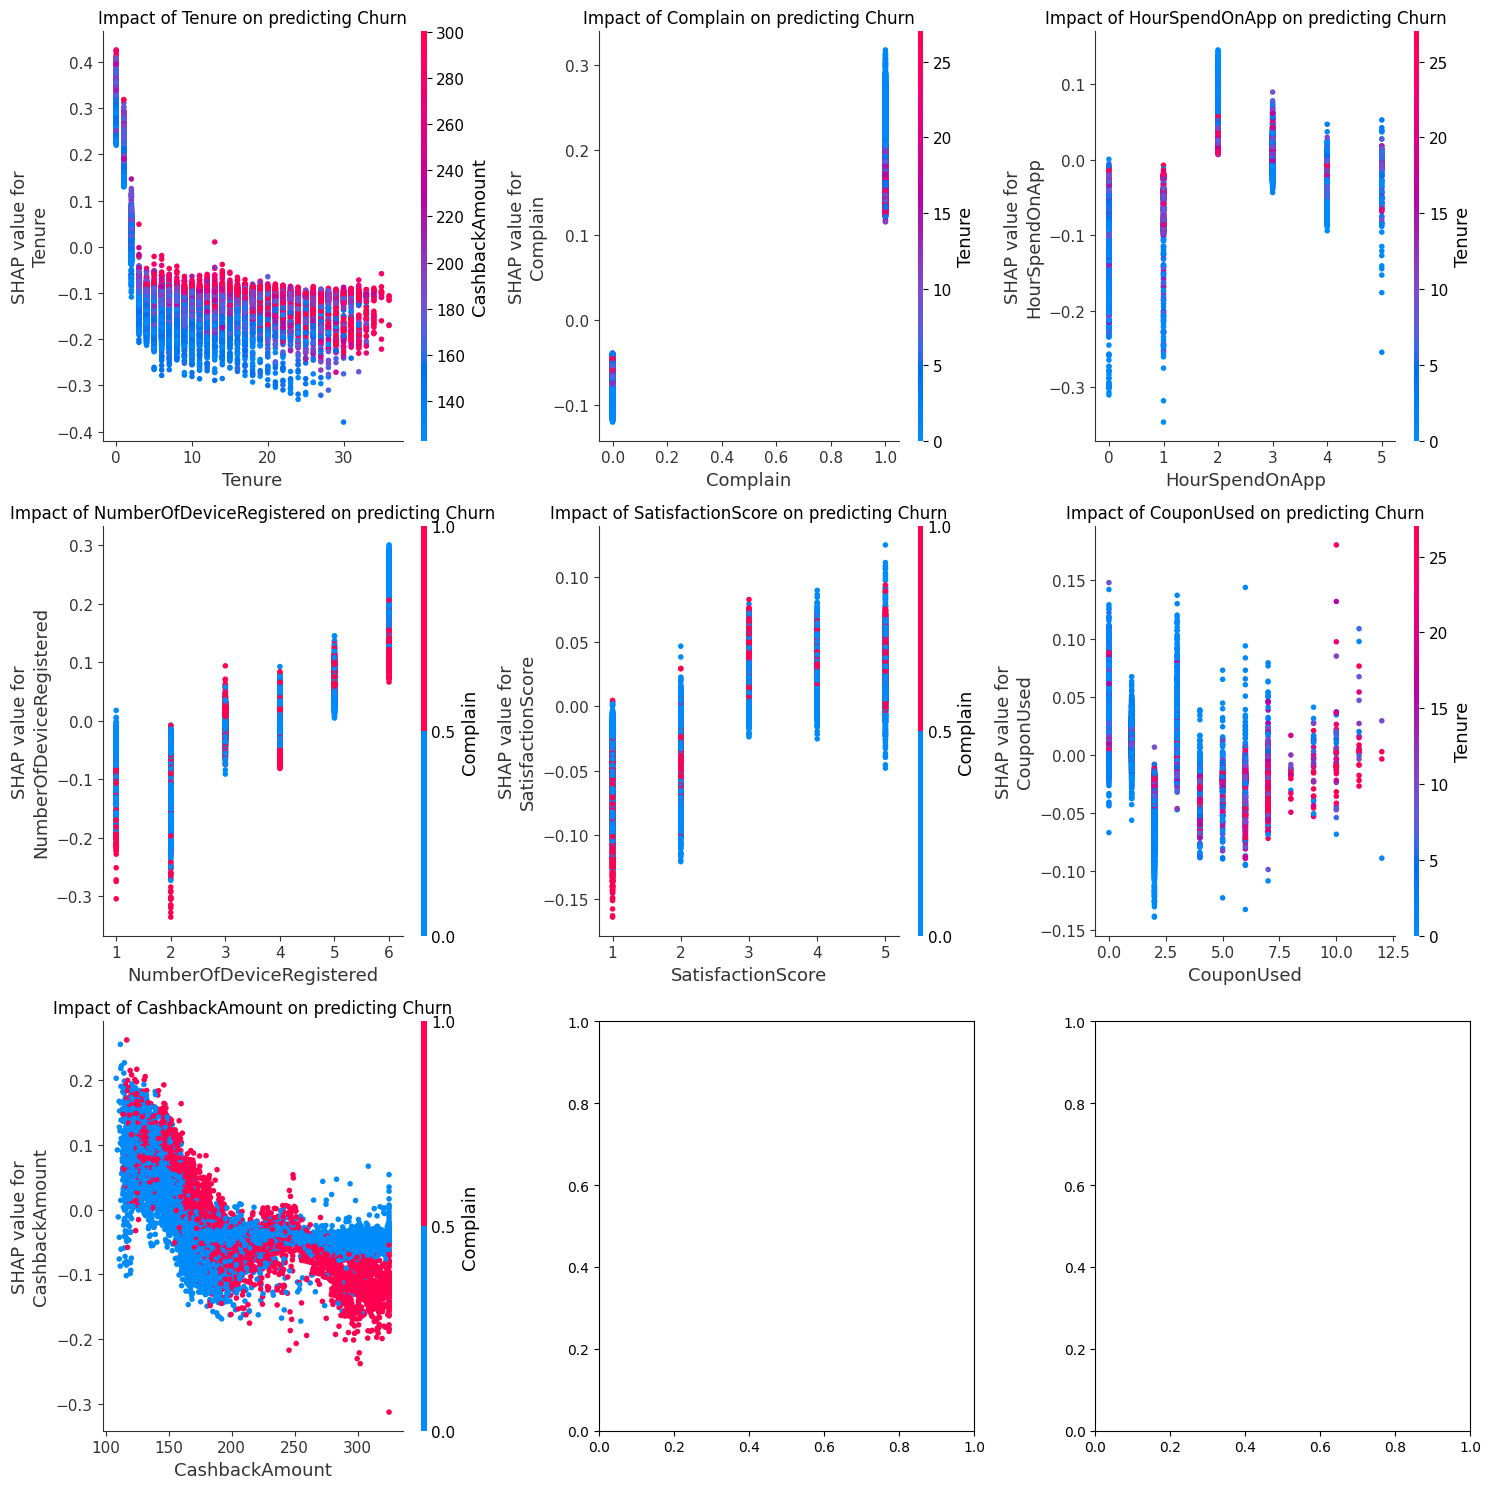

In [19]:
features = ['Tenure', 'Complain','HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore',
       'CouponUsed','CashbackAmount']

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, column in enumerate(features):
    shap.dependence_plot(column, shap_values[..., 1], X_test, ax=axes[i], show = False)
    axes[i].set_title(f'Impact of {column} on predicting Churn')

plt.tight_layout()
plt.show()

Partial Dependence Plots show the marginal effect of a feature on the predicted outcome of the model, holding all other features constant.
Peaks in PDP show the feature values where the predicted probability/ likeliness of churn is highest.

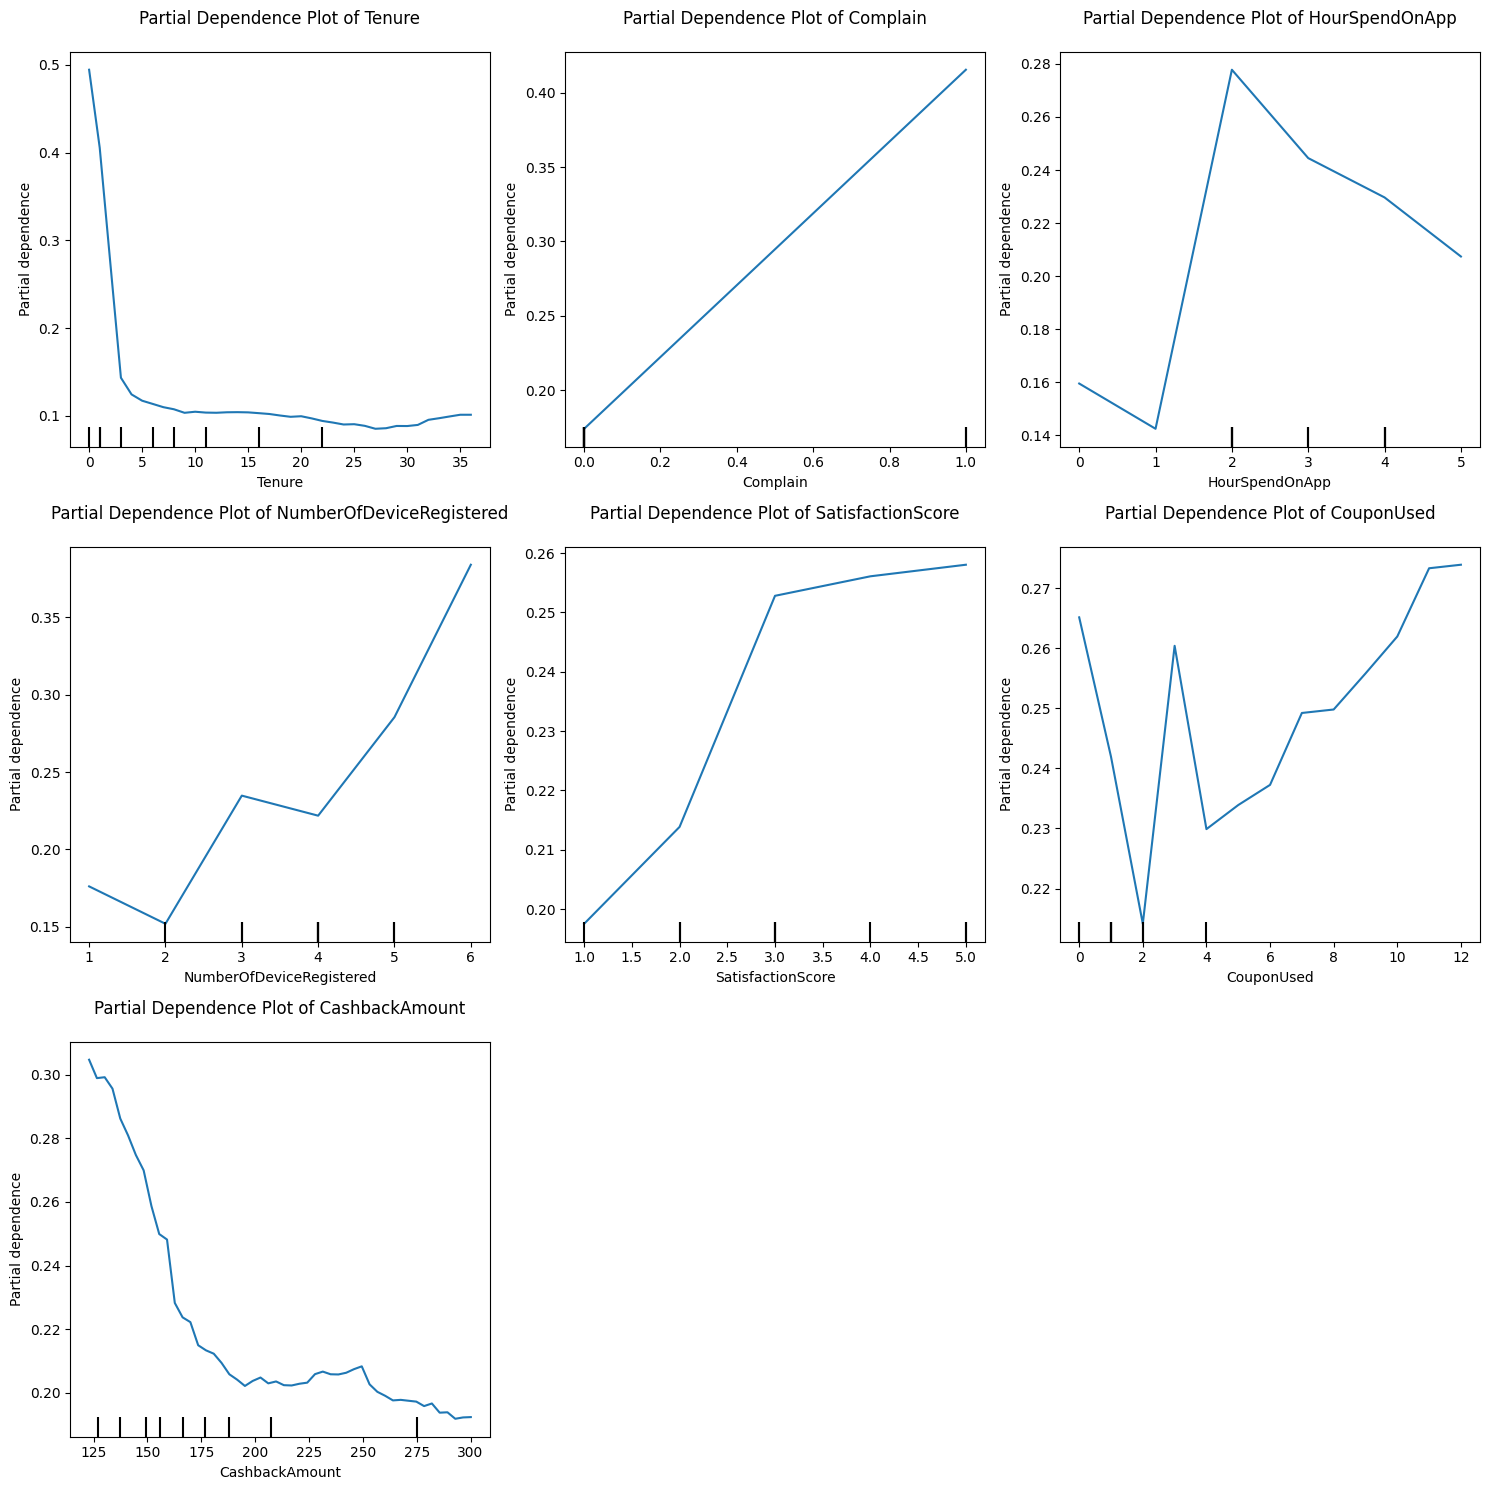

In [20]:
plt.figure(figsize=(15, 15))

for i, column in enumerate(features):
    ax = plt.subplot(3,3, i+1)
    PartialDependenceDisplay.from_estimator(best_rf, X_test, [column], grid_resolution=50, ax=ax,n_jobs=-1)
    ax.set_title(f'Partial Dependence Plot of {column}', pad = 20)

plt.tight_layout()
plt.show()

Feature importance, SHAP values and PDP plots reinforce the trends: customers with tenure under 2 years, who make complaints, receive limited cashback are more likely to churn. We also see other similar traits: high number of devices registered, moderate app engagement (around 2 hours), and average satisfaction scores (3).

## Analyzing current retention strategies

We now evaluate the effectiveness of our current retention strategy, specifically email campaigns. With available data on email engagement, we conducted an A/B test by dividing 5000 customers into two groups—those who received the email (treatment) and those who did not (control). By comparing churn, purchase, and engagement rates between these groups, we aim to assess the campaign’s impact on customer retention.

In [21]:
file_id = '18vQH7gJSwDERaNC0C6iKT-JCwvLVTT1G'
url = f'https://drive.google.com/uc?id={file_id}'
output2 = 'campaign_treatment.csv'
gdown.download(url, output2, quiet=False)

file_id = '191GUoj101TB5SIw4xALcjTxhIFh9MI-d'
url = f'https://drive.google.com/uc?id={file_id}'
output3 = 'campaign_control.csv'

gdown.download(url, output3, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=18vQH7gJSwDERaNC0C6iKT-JCwvLVTT1G
To: c:\Users\CelesteN\Documents\nus resources\dsa3101\Project\DSA3101-Project\customer_behaviour\campaign_treatment.csv
100%|██████████| 134k/134k [00:00<00:00, 7.04MB/s]
Downloading...
From: https://drive.google.com/uc?id=191GUoj101TB5SIw4xALcjTxhIFh9MI-d
To: c:\Users\CelesteN\Documents\nus resources\dsa3101\Project\DSA3101-Project\customer_behaviour\campaign_control.csv
100%|██████████| 123k/123k [00:00<00:00, 538kB/s]


'campaign_control.csv'

In [22]:
control_grp = pd.read_csv('campaign_control.csv')
treatment_grp = pd.read_csv('campaign_treatment.csv')

ab_test_data = pd.concat([control_grp, treatment_grp])

# Calculate and print metrics for each group
summary = ab_test_data.groupby('group').mean()[['is_opened', 'is_purchased', 'churned']]
print(summary)

ab_test_data = pd.concat([control_grp, treatment_grp])

# A/B test: Checking if churn rate difference between groups is significant
control_churn_count = control_grp['churned'].sum()
treatment_churn_count = treatment_grp['churned'].sum()

count = np.array([control_churn_count, treatment_churn_count])
nobs = np.array([len(control_grp), len(treatment_grp)])
stat, pval = proportions_ztest(count, nobs)

print(f"\nZ-test statistic: {stat}")
print(f"P-value: {pval}")


           is_opened  is_purchased  churned
group                                      
Control       0.0000        0.0008   0.2340
Treatment     0.1906        0.0250   0.2294

Z-test statistic: 0.5451291457385136
P-value: 0.5856646984442679


From the results above, we see that while the email campaign increases purchase and open rates in the treatment group, it does not significantly reduce churn. Currently, we lack data on other potential retention strategies implemented by the platform, which limits our ability to measure their effectiveness directly. However, insights from our previous churn analysis suggest new retention strategies that could be explored.

## Proposed retention strategies

Feature importance analysis highlighted `Tenure`, `Complain`, and `CashbackAmount` as the top predictors of customer churn. As such, we propose three possible strategies that can be employed to improve customer retention and lifetime value:

1. Onboarding and Engagement for New Customers : Many at-risk customers have a tenure of less than 2 years, indicating newer customers are more likely to churn.
   - Proposed Strategy: Implement early-stage onboarding programs, such as tutorials, welcome discounts, or incentives for app engagement. These could enhance new customer experiences and improve retention by extending customer tenure.

2. Complaints: A higher proportion of churned customers reported complaints, suggesting dissatisfaction is a significant factor in churn.
   - Proposed Strategy: Implement a more responsive customer support system to address complaints quickly. Consider offering personalized solutions, such as direct follow-ups or compensations (e.g., discounts or cashback) for those who complain. Additionally, A/B testing different customer service interventions could help identify the most effective ways to retain customers who have expressed dissatisfaction.

3. Cashback Incentives: Most at-risk customers receive around less than $150 in cashback, with limited use of higher cashback levels.
   - Proposed Strategy: Introduce tiered cashback incentives, such as increased cashback for higher spending. Experiment with this strategy to encourage repeat purchases and spending among at-risk customers.

Unfortunately, there is currently insufficient data for us to analyse the potential impacts or improvements of these strategies on churn. As the e-commerce platform collects more data through the newly implemented retention strategies or additional A/B tests, we can then incorporate the data into our analysis. This will enable us to refine and optimize retention strategies, aligning them more closely with customer behavior and preferences to ultimately improve customer retention and lifetime value.